In [1]:

import numpy as np
import itertools
import main_module as mm
import importlib
import networkx as nx
import matplotlib.pyplot as plt
import os

## Compute Mutual transitivity

In [53]:
# ===== parameters for optimization =====
experr_tol = 0.2 # less than 20% error is acceptable 
importlib.reload(mm)
conc_lb, FuncPieceError, max_path_length = mm.get_optimization_params()

# ===== phase space to explore =====
n = 3
# The ranges of X, Y, and Z are set besed on the rough scan of the phase space 
X = np.linspace(np.log10(1e-6),np.log10(10),n) 
Y = np.linspace(np.log10(1e-6),np.log10(300),n) 
Z = np.linspace(np.log10(1e-6),np.log10(1-1e-5),n)

In [ ]:
importlib.reload(mm)
# ===== main part =====
result = []
for source_indices in itertools.product(X,Y,Z):
    for target_indices in itertools.product(X,Y,Z):
        source = [10**_ for _ in source_indices]
        target = [10**_ for _ in target_indices]
        
        FuncPieceError = 1e-5
        while FuncPieceError > 9e-7:
            print(f'FuncPieceError: {FuncPieceError}')
            res = mm.compute_transitivity(source, target, conc_lb, max_path_length, FuncPieceError=FuncPieceError, experr_tol=experr_tol)
            if res[4] < experr_tol:
                break
            FuncPieceError = FuncPieceError*0.6

        result.append(source+target+[res[1], res[4]])



### Export the result

In [13]:
# ===== save the result =====
# os.makedirs('result', exist_ok=True)
#with open('result/Hasse.txt','w') as fp:
#    for r in result:
#        fp.write(' '.join([str(_) for _ in r])+'\n')

### Import the result


In [3]:
result = np.loadtxt('result/Hasse.txt')

### Plot the max violation

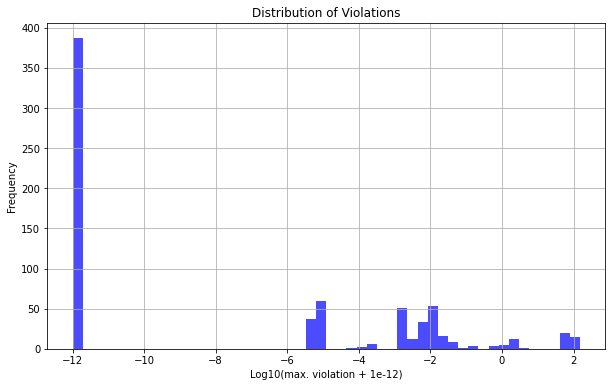

In [4]:
mm.plot_maxviol([[i,result[i,6]] for i in range(np.shape(result)[0])])

In [5]:
def FindNode(point, nodes, X, Y, Z):
    x, y, z = np.log10(point)
    x, y, z = (x-np.min(X))/(np.max(X)-np.min(X)), (y-np.min(Y))/(np.max(Y)-np.min(Y)), (z-np.min(Z))/(np.max(Z)-np.min(Z))

    dist_list = [(x-nodes[f'C{i}'][0])**2 + (y-nodes[f'C{i}'][1])**2 + (z-nodes[f'C{i}'][2])**2 for i in range(len(nodes))]
    return f'C{np.argmin(dist_list)}'

## Plot the transition diagram

The nodes are colored by rgb based on (x,y,z)

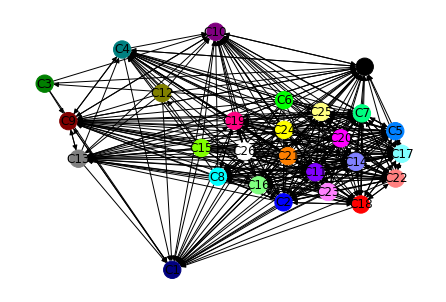

In [6]:
violation_threshold = 1e-9
# Example node data: node ID mapped to 3 features (each feature in the range 0 to 1)
count = 0
node_data = {}
for state in itertools.product(X,Y,Z):
    node_data[f'C{count}'] = ((state[0]-np.min(X))/(np.max(X)-np.min(X)), (state[1]-np.min(Y))/(np.max(Y)-np.min(Y)),(state[2]-np.min(Z))/(np.max(Z)-np.min(Z)))
    count += 1
# Example edge list
edges = []
for i in range(np.shape(result)[0]):
    violation = result[i,6]
    if violation > violation_threshold:
        continue

    source = FindNode(result[i,:3], node_data, X, Y, Z)
    target = FindNode(result[i,3:6], node_data, X, Y, Z)

    if source != target:
        edges.append((source, target))

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph
G.add_nodes_from(node_data.keys())
G.add_edges_from(edges)

# Map node features to RGB colors
colors = [node_data[node] for node in G.nodes()]

# Draw the graph
pos = nx.spring_layout(G)  # positions for all nodes

nx.draw(G, pos, node_color=colors, with_labels=True, arrows=True)

# Show the graph
plt.show()


The rgb coloring is hard to see. Instead, I compute strongly connected components and draw the transition diagram among them.


In [ ]:
sccs = list(nx.strongly_connected_components(G))

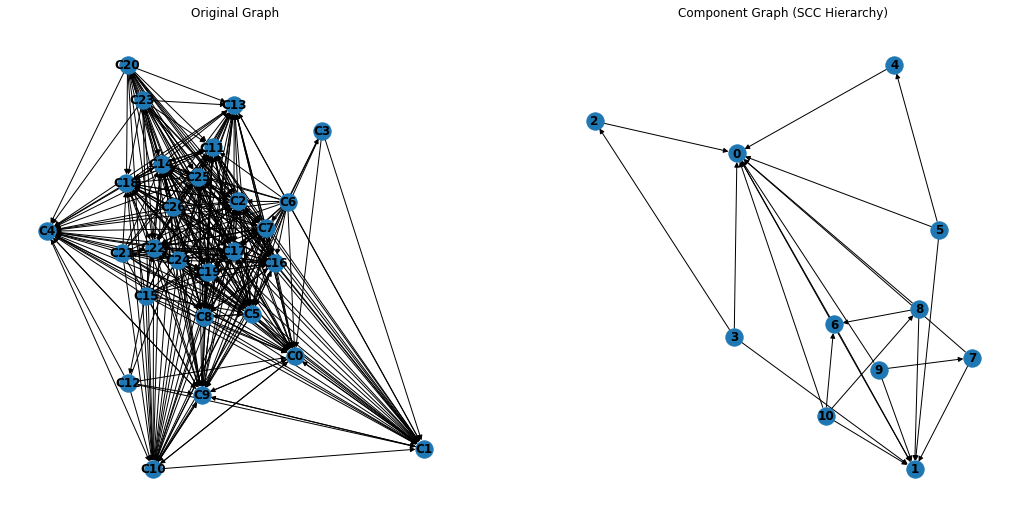


Component Graph Nodes (representing SCCs):
(0, {'members': {'C10', 'C13', 'C9', 'C0', 'C1', 'C4'}})
(1, {'members': {'C16', 'C18', 'C11', 'C22', 'C2', 'C25', 'C14', 'C7', 'C17', 'C19', 'C5', 'C8'}})
(2, {'members': {'C3'}})
(3, {'members': {'C6'}})
(4, {'members': {'C12'}})
(5, {'members': {'C15'}})
(6, {'members': {'C20'}})
(7, {'members': {'C21'}})
(8, {'members': {'C23'}})
(9, {'members': {'C24'}})
(10, {'members': {'C26'}})


In [14]:
component_graph = nx.condensation(G, sccs)

# Visualization
plt.figure(figsize=(18, 9))

plt.subplot(1, 2, 1)
nx.draw(G, with_labels=True, font_weight='bold')
plt.title('Original Graph')

plt.subplot(1, 2, 2)
nx.draw(component_graph, with_labels=True, font_weight='bold')
plt.title('Component Graph (SCC Hierarchy)')

plt.show()

print("\nComponent Graph Nodes (representing SCCs):")
for node in component_graph.nodes(data=True):
    print(node)

### Data files and a script file to generate Fig.4A

In [34]:
bases = [[np.min(X),np.max(X)],[np.min(Y),np.max(Y)],[np.min(Z),np.max(Z)]]

os.makedirs('Cytoscape/SCCS', exist_ok=True)
pt_list = [5,7,9] # rectangle, circle, triangle
lc_list = ['#FFCABF','#FFFF80','#77D9A8','#FFFFFF']

# output all the node point in each SCC
for i,scc in enumerate(sccs):
    with open(f'CytoScape/SCCS/SCC{i}.txt','w') as fp:
        for node in scc:
            fp.write(' '.join([str(_*(bases[j][1]-bases[j][0])+bases[j][0]) for j,_ in enumerate(node_data[node])])+'\n')

# output the grid line on lattice
output = ''
with open('Cytoscape/SCCS/grid.txt','w') as fp:
    for i in range(n):
        for j in range(n):
            output += f'{0.5*i*(bases[0][1]-bases[0][0])+bases[0][0]} {0.5*j*(bases[1][1]-bases[1][0])+bases[1][0]} {0*(bases[2][1]-bases[2][0])+bases[2][0]}\n{0.5*i*(bases[0][1]-bases[0][0])+bases[0][0]} {0.5*j*(bases[1][1]-bases[1][0])+bases[1][0]} {1*(bases[2][1]-bases[2][0])+bases[2][0]}\n\n\n'
            output += f'{0.5*i*(bases[0][1]-bases[0][0])+bases[0][0]} {0*(bases[1][1]-bases[1][0])+bases[1][0]} {0.5*j*(bases[2][1]-bases[2][0])+bases[2][0]}\n{0.5*i*(bases[0][1]-bases[0][0])+bases[0][0]} {1*(bases[1][1]-bases[1][0])+bases[1][0]} {0.5*j*(bases[2][1]-bases[2][0])+bases[2][0]}\n\n\n'
            output += f'{0*(bases[0][1]-bases[0][0])+bases[0][0]} {0.5*i*(bases[1][1]-bases[1][0])+bases[1][0]} {0.5*j*(bases[2][1]-bases[2][0])+bases[2][0]}\n{1*(bases[0][1]-bases[0][0])+bases[0][0]} {0.5*i*(bases[1][1]-bases[1][0])+bases[1][0]} {0.5*j*(bases[2][1]-bases[2][0])+bases[2][0]}\n\n\n'
            
    fp.write(output)

# plot script
output = 'set term postscript eps enhanced color "Times-Roman,20"\nunse key\nset view 52,19,1,1\nset xlabel "x"\nset ylabel "y"\nset zlabel "z"\nset xrange [-6.2:1.2]\nset yrange [-6.2:3]\nset zrange [-6:0]\n'
output += 'se xtics("10^{-6}"-6,"10^{-3}"-3,"1"0)\n'
output += 'se ytics("10^{-6}"-6,"10^{-3}"-3,"1"0,"10^{3}"3)\n'
output += 'se ztics("10^{-6}"-6,"10^{-3}"-3,"1"0)\n'
output += 'se ticslevel 0.1\n'
output += 'se out "grid.eps"\n'

output += 'sp "grid.txt" u 1:2:3 w l lw 2 dt(5,3) lc rgb "#999999" t "",'
for i,scc in enumerate(sccs):
    pt, lc = int(np.floor(i/len(lc_list))), i%len(lc_list)
    output += f'"SCC{i}.txt" u 1:2:3 w p pt {pt_list[pt]} ps 2.5 lc rgb "{lc_list[lc]}" t "SCC{i}", "SCC{i}.txt" u 1:2:3 w p ps 2.6 pt {pt_list[pt]-1} lc rgb "#4d4d4d" lw 3 t "",'
output = output[:-1]
with open('Cytoscape/SCCS/plot.gp','w') as fp:
    fp.write(output)

### Export Cytoscape Datafile (For Fig.4B)

In [13]:
os.makedirs('Cytoscape', exist_ok=True)
output = 'nodeID,label,feature1,feature2,feature3\n'
for node in node_data:
    output += f'{node},Node,{node_data[node][0]},{node_data[node][1]},{node_data[node][2]}\n'
with open('Cytoscape/Hasse_node.csv','w') as fp:
    fp.write(output)

output = 'source,target,interaction,weight\n'
for edge in edges:
    output += f'{edge[0]},{edge[1]},Directed,1\n'
with open('Cytoscape/Hasse_edge.csv','w') as fp:
    fp.write(output)

edges = component_graph.edges()
output = 'source,target,interaction,weight\n'
for edge in edges:
    output += f'{edge[0]},{edge[1]},Directed,1\n'
with open('Cytoscape/Hasse_component_graph_edge.csv','w') as fp:
    fp.write(output)


### Compute Convex-Hull and check if the attractor is contained

In [54]:
from scipy.spatial import ConvexHull, Delaunay

data = np.loadtxt('result/glyc_survive_dead.csv',delimiter=',')
single_point = np.log10(data[1][:3])
single_point[0] = (single_point[0]-np.min(X))/(np.max(X)-np.min(X))
single_point[1] = (single_point[1]-np.min(Y))/(np.max(Y)-np.min(Y))
single_point[2] = (single_point[2]-np.min(Z))/(np.max(Z)-np.min(Z))

# Example set of points (replace with your data)
points = np.array([node_data[list(sccs[0])[i]] for i in range(len(sccs[0]))])

# Compute the convex hull of the set of points
hull = ConvexHull(points)

# Create a Delaunay triangulation of the hull points
tri = Delaunay(points[hull.vertices])

# Check if the single point is inside the convex hull
is_inside = tri.find_simplex(single_point) >= 0

print(f"Is the point inside the convex hull? {is_inside}")


Is the point inside the convex hull? True
